In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.getcwd()

'/Users/pasqualinodipilla/multimodal-synthetic-biomedical'

In [3]:
data = np.load("data/parkinson/processed/parkinson_T6_motor_UPDRS.npz", allow_pickle=True)

X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

feature_cols = list(data["feature_cols"])

X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(feature_cols)

((4475, 6, 20), (4475,), (1190, 6, 20), (1190,), 20)

Sequence shape: (6, 20)
Target motor_UPDRS: 29.435


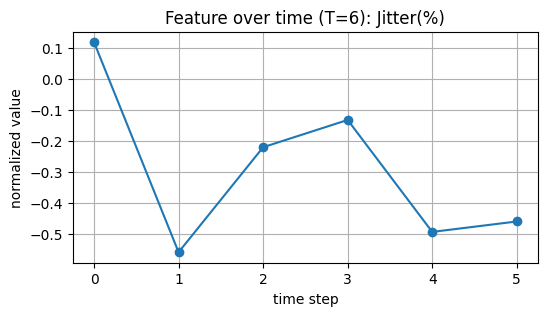

In [5]:
#visualizzo una sequenza (sanity check)
i=0
seq = X_train[i] #shape (6,20)
target = y_train[i] #scalar

print("Sequence shape:", seq.shape)
print("Target motor_UPDRS:", target)

j=4 #feature index (posso cambiare da 0...19)
plt.figure(figsize=(6,3))
plt.plot(seq[:,j], marker="o")
plt.title(f"Feature over time (T=6): {feature_cols[j]}")
plt.xlabel("time step")
plt.ylabel("normalized value")
plt.grid(True)
plt.show()

In [12]:
import torch
from pathlib import Path

device = "mps" if torch.backends.mps.is_available() else "cpu"

ckpt_path = Path("clinical_longitudinal/outputs/baseline_gru_best.pt")
state = torch.load(ckpt_path, map_location="cpu")  # cpu per leggere shape

# stampa le chiavi (debug)
print("Num tensors in checkpoint:", len(state))
print("First 10 keys:", list(state.keys())[:10])

# deduco input_size e hidden_size dal tensore GRU weight_ih_l0
W_ih = state["gru.weight_ih_l0"]          # shape: (3*hidden, input)
three_h, input_size = W_ih.shape
hidden_size = three_h // 3

print("Deduced input_size =", input_size)
print("Deduced hidden_size =", hidden_size)

# deduco num_layers contando quanti weight_ih_l{k} ci sono
num_layers = len([k for k in state.keys() if k.startswith("gru.weight_ih_l")])
print("Deduced num_layers =", num_layers)


Num tensors in checkpoint: 8
First 10 keys: ['gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0', 'head.0.weight', 'head.0.bias', 'head.1.weight', 'head.1.bias']
Deduced input_size = 20
Deduced hidden_size = 64
Deduced num_layers = 1


In [13]:
import torch.nn as nn

class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        yhat = self.head(last).squeeze(-1)
        return yhat

model = GRURegressor(input_size, hidden_size, num_layers=num_layers).to(device)


In [14]:
state = torch.load(ckpt_path, map_location=device)
missing, unexpected = model.load_state_dict(state, strict=True)
print("Loaded OK.")
print("missing:", missing)
print("unexpected:", unexpected)

model.eval()


Loaded OK.
missing: []
unexpected: []


GRURegressor(
  (gru): GRU(20, 64, batch_first=True)
  (head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [20]:
import numpy as np

data = np.load("data/parkinson/processed/parkinson_T6_motor_UPDRS.npz", allow_pickle=True)
X_test = data["X_test"]
y_test = data["y_test"]

with torch.no_grad():
    xb = torch.tensor(X_test, dtype=torch.float32).to(device)
    preds = model(xb).cpu().numpy()

print("preds:", np.round(preds, 2))
print("true :", np.round(y_test,2))

preds: [29.96 30.13 30.68 ... 16.68 16.04 15.67]
true : [31.   31.23 31.48 ... 15.64 15.4  15.17]


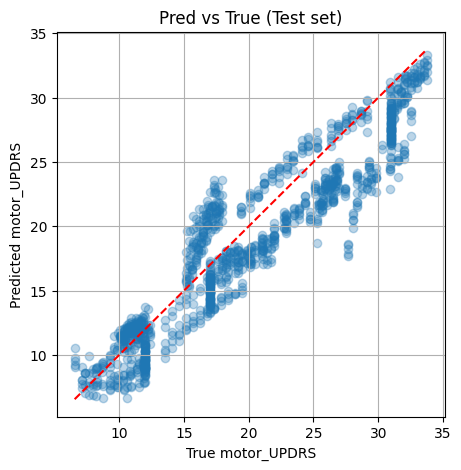

In [ ]:
#scatter pred vs true
plt.figure(figsize=(5,5))
plt.scatter(y_test, preds, alpha=0.3)
mn = min(y_test.min(), preds.min())
mx = max(y_test.max(), preds.max())
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("True motor_UPDRS")
plt.ylabel("Predicted motor_UPDRS")
plt.title("Pred vs True (Test set)")
plt.grid(True)
plt.show()

#a valori bassi le predizioni sono abbastanza buone ma un pò compresse
#nella fascia media più dispersione verticare -> errore maggiore
#a valori alti alcuni punti stanno sotto la diagonale -> il modello tende a sottostimare i casi più gravi
#(regressione verso la media -> le reti mse tengono a tirare verso il centro)

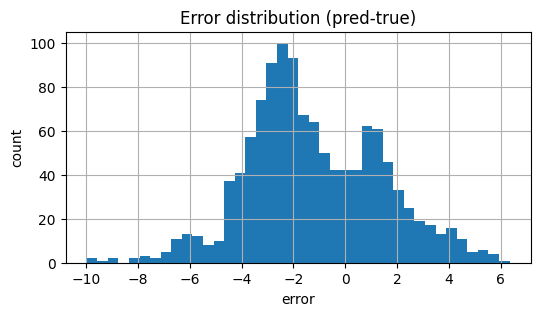

Mean error: -1.2120448
Std error: 2.608742


In [ ]:
#distribuzione errori
errors = preds - y_test

plt.figure(figsize=(6,3))
plt.hist(errors, bins=40)
plt.title("Error distribution (pred-true)")
plt.xlabel("error")
plt.ylabel("count")
plt.grid(True)
plt.show()

print("Mean error:", errors.mean())
print("Std error:", errors.std())

#errore negativo -> il modello sottostima
#in particolare in media il modello predice 1.2 punti updrs in meno rispetto al valore reale
#(bias sistematico verso il basso, come si vedeva anche nello scatter)

#istogramma: distribuzione centrata attorno a -2 circa, coda sinistra più lunga (errori molto negativi fino a -9/-10)
#coda destra più corta ->
#il modello sbaglia più pesantemente sottostimando che sovrastimando

#dev std : tipicamente l'errore è +-2.6 punti updrs (per un punteggio 8-35 non è poi così male, anche se
#clinicamente 2-3 punti potrebbero essere importanti, da rivedere).

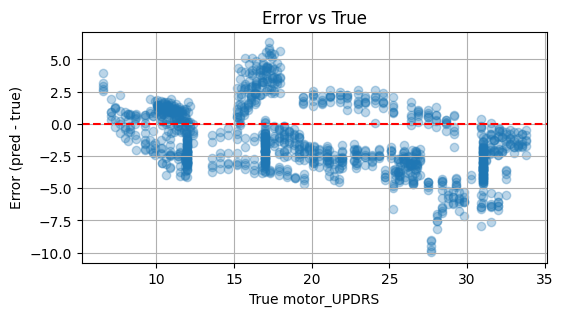

In [ ]:
#errore vs true (per vedere bias)
plt.figure(figsize=(6,3))
plt.scatter(y_test, errors, alpha=0.3)
plt.axhline(0,color="red", linestyle="--")
plt.xlabel("True motor_UPDRS")
plt.ylabel("Error (pred - true)")
plt.title("Error vs True")
plt.grid(True)
plt.show()

#asse x -> valore vero (motor_UPDRS), asse y -> errore = pred - true
# linea rossa -> errore = 0 (pred perfetta)

#per valori bassi -> errori leggermente più negativi, abbastanza stretti -> buon modello per pazienti lievi
#fascia media -> due bande una sopra lo zero (sovrastima), una sotto lo zero (sottostima)
#questo potrebbe indicare cluster di pazienti diversi o che la gru non riesce a catturare una struttura latente

#fascia alta -> pazienti severi > 25/27
#errori quasi tutti negativi -> il modello sottostima sistematicamente i casi gravi

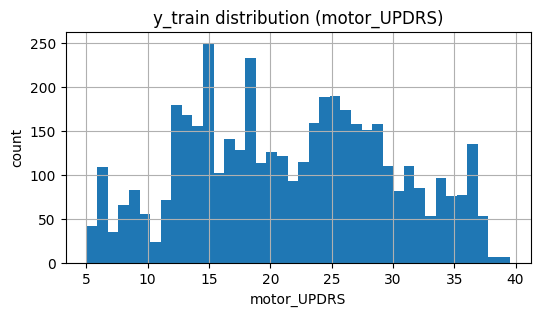

In [ ]:
#quale potrebbe essere la causa? probabilmente ho pochi pazienti severi nel training e questo si aggiugne all'effetto
#regressione verso la media dell'mse, vediamo:

#non è vero ->  ho abbastanza severi anche sopra 25
plt.figure(figsize=(6,3))
plt.hist(y_train, bins=40)
plt.title("y_train distribution (motor_UPDRS)")
plt.xlabel("motor_UPDRS")
plt.ylabel("count")
plt.grid(True)
plt.show()
#

In [ ]:
#potrei avere una limitata capacità del modello:
#architettura mia: GRU(hidden=64, 1 layer) -> LayerNorm -> Linear

#forse è una baseline piccola che non riesce a modellare bene la dinamica nei casi severi e inoltre perdo informazione usando solo
#l'ultimo step (nel forward faccio last=out[:,-1,:] quindi butto via info dei primi 5 time step)

#per ora non cambio nulla, semplicemente dico che la baseline gru mostra regressione verso la media nei casi severi
#vediamolo meglio quantificando il bias per fascia
bins = [0,15,25,40]

for i in range(len(bins)-1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    print(f"Range {bins[i]}-{bins[i+1]}:")
    print(" Mean error:", (preds[mask]-y_test[mask]).mean())
    print(" Count:", mask.sum())

#e in effetti nel range 25-40 l'errore medio è molto più negativo

Range 0-15:
 Mean error: -0.5521188
 Count: 331
Range 15-25:
 Mean error: -0.24418004
 Count: 477
Range 25-40:
 Mean error: -2.9924297
 Count: 382


In [ ]:
#come migliorare?

#1) uso tutta la sequenza non solo l'ultimo step 
    #- mean pooling: media di out su tutti i time step
    #- attention pooling: il modello impara quali visite pesano di più
#2) aumentare la capacità/regolarizzazione -> hidden_size 64 -> 128, num_layers 1->2 (con dropout), early stopping
    #(riduce underfit cioè che se il modello è troppo piccolo schiaccia verso la media)
#3) motor_UPDRS non ha una distribuzione molto strana, ma potrei provare a standardizzare  il target o
    #predire delta UPDRS (variazione) invece del valore assoluto

#4) potrei cambiare loss -> tipo con mse io sto dicendo che mi interessa evitare errori grandi mediamente
                            #quindi il modello evita predizioni estreme (regressione verso la meida)
                            #se gli estremi sono piu rari o rumorosi non vale la pena considerarli molto
    #potrei usare MAE (L1) -> penalizza linearmente gli errori (meno spinta a stare al centro rispetto a mse)
    #huber loss -> compromesso: mse per errori piccoli, mae per grandi
    # weighted loss -> do più peso ai casi severi (tipo y>28 pesa 2x o 3x)
      #quindi il modello non ignora gli estremi

#per ora lascio così